# Forecasting number of dwelling units approved.

## Problem specification

Obtain publicly available data from Australia Bureau of Statistics Beta API and predict number of 
dwelling units approved in the New South Wales region.



## Understanding JSON structure

The [URL]("http://stat.data.abs.gov.au/sdmx-json/data/ABS_BA_SA2_ASGS2016/1.9.1...0+1+102+1GSYD+10201.M/all?detail=Full&dimensionAtObservation=AllDimensions&startPeriod=2011-07&endPeriod=2017-07") to the data source contains the following information.

1. Dataset Identifier: ABS_BA_SA2_ASGS2016
2. Measure: Total number of dwelling units(ID:1)
3. Sector of work: Total Sectors(id:9)
4. Type of work: New(id:1)
5. Type of building: all
6. Region: [Gosford, Central Coast, New South Wales, Australia]
7. Frequency: Monthly
8. Start time: 2011-07
9. End time: 2017-07




## Data transformation and time series extraction

Data downloaded from the given URL contains headers, data and meta data or structure of the data.
We have to extract only the observations and transform the observations into the data-frame. Later, required time series needs to be extracted.

Below are the steps followed to extract the time series for Total number of new houses in New South Wales.

1. Extract only the observations from downloaded json.

2. Extract time series from the observations using regular expression `'0:0:0:0:2:2:0:*`.
    
    In the regular expression, sixth field is the region and last field is the duration.
    Region value `2` is for New south wale region based on the structure.
    Particular time series is extracted using above pattern.

3. Pandas data-frame is created using the above resulting time series.
5. Data-frame is saved to a file.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Time series summary

Final time series contains 73 instances starting from 2011-07 to 2017-07.



In [36]:
df = pd.read_csv('./dataframe.csv')
df.head()


,months,Dwelling units
0,2011-07-31,1511.0
1,2011-08-31,1634.0
2,2011-09-30,1561.0
3,2011-10-31,1485.0
4,2011-11-30,1594.0


In [37]:
df.describe()

,Dwelling units
count,73.000000
mean,2009.178082
std,488.921783
min,982.000000
25%,1594.000000
50%,2007.000000
75%,2461.000000
max,3006.000000


In [38]:
df = df.set_index('months')

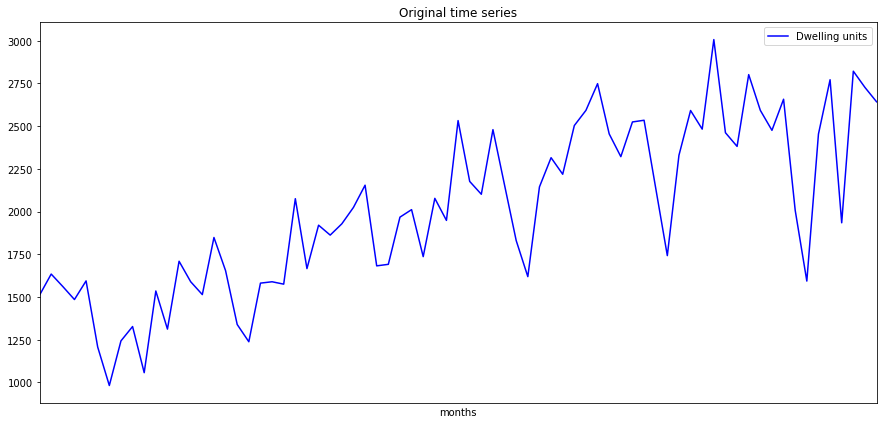

In [39]:
ig, ax = plt.subplots(figsize=(15, 7))
df.plot(x_compat=True, ax=ax, color='blue')
plt.legend(loc='best')
plt.title('Original time series')
ax.xaxis.set_tick_params(reset=False)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


## Components of Time series

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.


![image](./plots/time_series_components.png)

Important interferences
   1. Year on year number of dwelling units approved is increasing. It clearly shws that there is a trend in the time series.
   2.  We can also infer from the plot that there is a seasonality in the time series.


## Stationarity test

Once we know the patterns, trends, seasonality and cycles in the time series, we can check if the time series is stationary or not.
In this task, I have used rolling statistics and Dickey-Fuller tests.

### What is stationarity and non-stationarity
A stationary (time) series is one whose statistical properties such as the mean, variance and autocorrelation are all constant over time. Hence, a non-stationary series is one whose statistical properties change over time.

### Rolling stastics
An average represents the “middling” value of a set of numbers. The moving average is exactly the same, but the average is calculated several times for several subsets of data



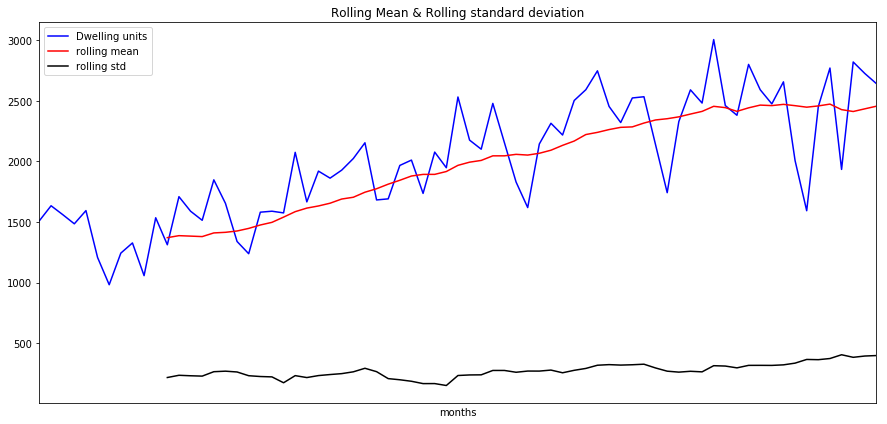

In [40]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
fig, ax = plt.subplots(figsize=(15,7))
df.plot(x_compat=True, ax=ax, color='blue', label='original')
plt.plot(rolling_mean, color='red', label='rolling mean')
plt.plot(rolling_std, color='black', label='rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Rolling standard deviation')
ax.xaxis.set_tick_params(reset=False)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


Moving average and moving standard deviations are not constants. Hence, the time series is not stationary.

### Dickey-Fuller test

   
    Dickey-Fuller test results with original time series
    Test statistic            -1.639759
    p-value                    0.462387
    Lags used                 12.000000
    Number of observations    60.000000
    critical values (1%)      -3.544369
    critical values (5%)      -2.911073
    critical values (10%)     -2.593190

Dickey-Fuller test with autolag `ÀIC` is used to test the stationarity of the time series.
In the test results, p-value > 0.05, it means data has unit roots. Also, test statistic value is greater than the critical values.
Hence, the time series is non-stationary.


## Making time series stationary

### Applying log scale

![image](./plots/log_scale.png)

Log scale is applied to the original time series and stationary tests results show that the time series is non-stationary.

    Dickey-Fuller test results with Log scale time series
    Test statistic            -2.297622
    p-value                    0.172736
    Lags used                 12.000000
    Number of observations    60.000000
    critical values (1%)      -3.544369
    critical values (5%)      -2.911073
    critical values (10%)     -2.593190


### Log scale - moving average

![image](./plots/log_scale_minus_moving_average.png)

 Time series obtained by differencing the log scale data with moving average is tested for stationarity
 and stationary tests. The results show that the time series is non-stationary.

    Dickey-Fuller test results with Log scale - moving average time series
    Test statistic            -0.328929
    p-value                    0.921306
    Lags used                 11.000000
    Number of observations    50.000000
    critical values (1%)      -3.568486
    critical values (5%)      -2.921360
    critical values (10%)     -2.598662

### Differencing and Shifting

Time series obtained by differencing the log scale data and shifted log scale data is tested for stationarity and the results that time series is stationary.

![image](./plots/data_shift.png)

    Dickey fuller test results with shifting time series
    Test statistic            -3.478557
    p-value                    0.008555
    Lags used                 11.000000
    Number of observations    60.000000
    critical values (1%)      -3.544369
    critical values (5%)      -2.911073
    critical values (10%)     -2.593190


## ACF and PACF to find P and Q values
Auto correlation and partial auto correlation are used to find the optimal parameters `p` and `q`.

We have used lag difference 1 while making the time series stationary. Hence, d=1.

![image](./plots/acf_pacf_plot.png)

p and q values are inferred from the acf and pacf plots. They are as follows.

    p=1
    q=1  



## Build ARIMA model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMAResults

#Model firring
model = ARIMA(self.log_scale_data, order=(2, 1, 1))
results = model.fit(disp=-1)

#Prediction
results.plot_predict(1, 109)



    ARIMA(p,d,q) - Auto-regressive integrated moving average. 
    ARIMA models are the most commonly used models for forecasting non stationary time series
    which can be made stationary by means of differencing, deflatting, or logging.

With the parameters p,d and q in hand we are now building ARIMA model. The values found in the previous section are the approximate estimations.
ARIMA model is trained using different values of p and q. Better model is obtained using p=1 and q=0.

Below are the different combinations of the parameters ans their corresponding AIC, BIC and RSS.

**RSS**: Residual square sum.  
**BIC**: Bayesian information criterion.  
**AIC**: Akaike information criterion.  

|  p  | d | q  | RSS | AIC | BIC |
|-----|---|----|-----|-----|-----|
|1    | 1 | 2  |0.1592|-62.64|-51.26|
|1|1|0|0.0005|-50.29|-43.46|
|1|1|1|0.0012|-64.54|-55.43|
|2|1|1|0.0009|-57.50|-46.12|
|0|1|1|0.0205|-59.17|-52.34|
|2|1|0|0.0008|-59.49|-50.39|

## Predictions

Created three year forecast of the number of dwelling units approved. Below is the forecasting graph.

![image](./plots/predictions_three_years.png) 

Below are the actual and predicted values.
    
    [2765.5910849  2779.93436085 2764.81472373 2807.07099437 2834.06638185
     2846.1474206  2871.62033432 2896.91775641 2917.38889503 2940.55142131
     2964.66624025 2987.61680375 3011.08924997 3035.11616773 3059.02468854
     3083.12355632 3107.5327331  3132.07730253 3156.79597876 3181.74174841
     3206.87721586 3232.20223753 3257.73443242 3283.46844238 3309.40286297
     3335.54343632 3361.89099452 3388.44592132 3415.2107592  3442.18722763
     3469.376615   3496.78076067 3524.4014364  3552.24025513 3580.29895657
     3608.5793078 ]


**Note:** complete code can be found in [Github:time_series_analysis](https://github.com/kantharajucn/time_series_analysis)